In [42]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter('ignore')

class MatrixFactorizer:
    
    def __init__(self, df, seed=0, filling=0):
        
        self.seed = seed
        self.filling = filling
        self.df = df
        self.X = self.to_matrix(self.df)
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.U = None # Transformed data
        self.test_fraction = 0
        
        self.model = None
        
        self.W = None # U = WH
        self.H = None
    
    def to_td(self, x):
        
        if x == 0:
            return x
        
        splt = x.split(':')
        minutes = int(splt[0])
        splt = splt[1].split('.')
        seconds = int(splt[0])
        y = splt[1]
        if y[-1]=='m':
            y = y[:-1]
        milliseconds = int(y)

        return timedelta(minutes=minutes,
                         seconds=seconds,
                         milliseconds=milliseconds).total_seconds()

    def to_matrix(self, df):
        
        df = df.fillna(self.filling)
        df = df.drop(['Nom'], axis=1)        
        X = df.to_numpy()
        X = np.vectorize(self.to_td)(X)
        
        return X  
    
    def split(self, X, test_fraction=0.1):
        
        np.random.seed(self.seed)
        
        train = np.zeros_like(X)
        test = np.zeros_like(X)        
        pos = X.nonzero()
        pos = list(zip(pos[0], pos[1]))
        
        tr, te = train_test_split(np.arange(len(pos)), shuffle=True, random_state=self.seed, 
                                  test_size=test_fraction)
        
        for i, p in enumerate(pos):            
            if i in tr:
                train[p] = X[p]
            else:
                test[p] = X[p]
        
        return train, test
    
    def cv_split(self, test_fraction=0.1, val_fraction=0.2):
        
        self.test_fraction = test_fraction
        tr, te = self.split(self.X, test_fraction)
        tr, val = self.split(tr, val_fraction)
        self.X_train = tr
        self.X_test = te
        self.X_val = val
    
    def error(self, X):
        
        pos = X.nonzero()
        pred = self.U[pos]
        target = X[pos].T
    
        return ((pred-target)**2).sum()/target.shape/target.mean()
        
    def fit(self, k, init='nndsvd', beta_loss='frobenius', alpha=0, solver='cd'):
        
        self.cv_split()
        
        self.model = NMF(n_components=k, init=init, random_state=self.seed, 
                         beta_loss=beta_loss, alpha=alpha, solver=solver)
        self.H = self.model.fit_transform(self.X_train)
        self.W = self.model.components_
        
        self.U = self.H.dot(self.W)
        
        train_error = self.error(self.X_train)[0]
        val_error = self.error(self.X_val)[0]
        
        return train_error, val_error
    
    def test(self):
        
        return self.error(self.X_test)
    
    def grid_search(self, alphas=np.logspace(-4,0,5), verbose=0):
        
        self.cv_split()
        
        ks = np.arange(1, len(self.df.columns))
        solvers = ['cd', 'mu']
        inits = ['random']#, 'nndsvd', 'nndsva', 'nndsdvar']
        losses = ['frobenius', 'kullback-leibler']

        trs = {}
        vals = {}
        best_val = 1e5
        params = None
        
        for alpha in alphas:
            for solver in solvers:
                for init in inits:
                    for loss in losses:
                        trs[
                            'alpha={}, init={}, loss={}'.format(
                                alpha, init, loss
                            )
                        ] = []
                        vals[
                            'alpha={}, init={}, loss={}'.format(
                                alpha, init, loss
                            )
                        ] = []
                        for k in ks:
                            try:
                                e_tr, e_val = self.fit(k=k, init=init, solver=solver,
                                                     beta_loss=loss, alpha=alpha)
                                if verbose:
                                    print('k={},i={},l={},a={} - train: {}, val: {}'.format(
                                        k, init, loss, alpha, e_tr, e_val
                                    ))
                                trs[
                                    'alpha={}, init={}, loss={}'.format(
                                        alpha, init, loss
                                    )
                                ].append(e_tr)
                                vals[
                                    'alpha={}, init={}, loss={}'.format(
                                        alpha, init, loss
                                    )
                                ].append(e_val)
                                if e_val < best_val:
                                    best_val = e_val
                                    params = [k, solver, init, loss, alpha]
                            except Exception as e:
                                continue
                                
        history = {
            'train_loss': trs,
            'val_loss': vals,
            'best_val_loss': best_val,
            'best_params': params
        }
        
        return history
    
    def plot_history(self, history):
        
        ks = np.arange(1, len(self.df.columns))        
        trs = history['train_loss']
        vals = history['val_loss']

        plt.figure(figsize=(10,7))
        for params in trs.keys():
            try:
                plt.plot(ks, trs[params], label=params+' train')
                plt.plot(ks, vals[params], label=params+' val')
            except:
                continue
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.show()
        
    def final_fit(self, params):
        
        X_tr, _ = self.split(self.X, self.test_fraction)        
        k, solver, init, beta_loss, alpha = params
        
        self.model = NMF(n_components=k, init=init, random_state=self.seed, 
                         beta_loss=beta_loss, alpha=alpha, solver=solver)
        self.H = self.model.fit_transform(X_tr)
        self.W = self.model.components_
        
        self.U = self.H.dot(self.W)
        
        test_error = self.error(self.X_test)[0]
        
        return test_error
    
    def get_df(self):
        
        udf = pd.DataFrame(
                   columns=df.columns, 
                   data=np.hstack([df.Nom.to_numpy().reshape(-1,1), U])
               )
        return udf

In [43]:
path = 'data/ch/result_by_athlet/800/H_result_by_athlet.csv'
df = pd.read_csv(path)
mf = MatrixFactorizer(df)

In [44]:
history = mf.grid_search()

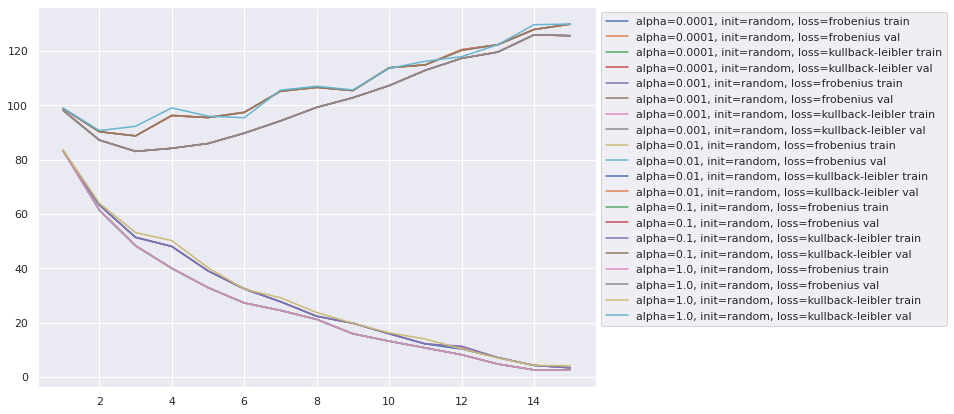

In [46]:
mf.plot_history(history)

In [47]:
history['best_params'], history['best_val_loss']

([3, 'cd', 'random', 'frobenius', 1.0], 82.98011542035813)

In [48]:
e_te = mf.final_fit(history['best_params'])
e_te

71.00587004907713

In [64]:
Udf = pd.DataFrame(
    columns=df.columns, 
    data=np.hstack([df.Nom.to_numpy().reshape(-1,1), U])
)
Udf

,Nom,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Frédéric Roggo,128.604,137.951,126.907,128.966,89.3571,80.5938,69.061,67.8056,66.205,88.2216,92.5744,93.4648,88.9885,77.8014,55.661
1,Dominic Müller,0,0,0.619558,15.4317,39.2024,81.0048,96.7274,94.9691,78.8489,84.1041,68.51,66.6096,65.9747,57.6807,41.2662
2,Léo Willemin,0,0,0.944422,0.710775,1.80564,3.73103,4.4552,4.37421,26.7051,69.477,96.1052,101.536,100.568,87.9256,62.9041
3,Romeo Nicoli,31.4758,33.7636,30.856,43.0635,51.0821,80.0865,88.9796,87.3621,58.1752,36.5443,6.0983,0.88595,0,0,0
4,Alessandro Schiavone,81.4121,87.3295,79.8089,74.6667,38.8485,14.4071,0,0,0,0,2.36927,2.29151,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Andrea Folchi-Vici,30.0231,32.2054,29.4319,27.8828,15.2087,7.1358,2.17654,2.13697,1.42303,0.893912,1.0005,0.845062,0,0,0
1865,Simon Käser,73.3717,78.7047,71.9268,68.9651,39.2608,21.764,10.4839,10.2933,6.85442,4.30579,2.74587,2.06519,0,0,0
1866,Jann Hayenga,0,0,0.936322,4.63788,11.782,24.3454,29.0706,28.5422,42.5947,79.0065,96.7167,100.665,99.7058,87.1714,62.3645
1867,Christoph Graf,4.74274,5.08747,5.00129,16.4725,33.0594,64.4743,75.9862,74.6049,58.5464,56.4169,40.2809,37.9715,37.4773,32.7659,23.4415
